<a href="https://colab.research.google.com/github/stvngo/Algoverse-AI-Model-Probing/blob/main/(Cached_Activations)_Dylan_Qwen3_0_6B_pts_LinearProbe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Packages

In [1]:
!pip install -q transformers accelerate einops



Load Qwen3-0.6B Model

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,  # reduce memory
    device_map="auto",          # auto to GPU if available
    trust_remote_code=True
)

print("Number of transformer layers:", len(model.model.layers)) # print layer count


Number of transformer layers: 28


Testing Prompt

In [3]:
prompt = "Q: If you have 12 apples and eat 5, then buy 3 more, how many do you have?\nA: Let's think step by step."
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
)

decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Truncate at the next question (if any)
answer = decoded.split("\nQ:")[0].strip()

print(answer)


Q: If you have 12 apples and eat 5, then buy 3 more, how many do you have?
A: Let's think step by step. First, we start with 12 apples. Then, we eat 5, so we have 12 - 5 = 7 apples left. After that, we buy 3 more, so we add 3 to the remaining 7, resulting in 7 + 3 = 10 apples. Therefore, the final number of apples is 10.


# Linear Probe

Loading Dataset

In [4]:
from huggingface_hub import login
from google.colab import userdata

# Get your secret token from Colab Secrets
HF_TOKEN = userdata.get('HF_TOKEN')

# Pass the token directly
login(token=HF_TOKEN)


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import torch

file_path = "/content/drive/My Drive/Algoverse-AI-Model-Probing/cached_activations_3/train_all_layers_acts.pth"
data = torch.load(file_path, map_location='cpu')

print(type(data))  # Should print <class 'dict'>
print(data.keys())  # Should show dict_keys(['pivotal', 'non_pivotal'])

layer_data = data[6]
print(type(layer_data))                 # Likely a dict
print(layer_data.keys())               # What keys are inside layer 6
print("Num pivotal:", len(layer_data['pivotal']))
print("Num non_pivotal:", len(layer_data['non_pivotal']))
print("Shape of one pivotal example:", layer_data['pivotal'][0].shape)

for layer_idx in data.keys():
    layer_data = data[layer_idx]
    pivot_acts = layer_data['pivotal']
    nonpivot_acts = layer_data['non_pivotal']

    print(f"Layer {layer_idx} - Pivotal: {len(pivot_acts)}, Non-Pivotal: {len(nonpivot_acts)}")



<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])
<class 'dict'>
dict_keys(['pivotal', 'non_pivotal'])
Num pivotal: 232
Num non_pivotal: 232
Shape of one pivotal example: torch.Size([1024])
Layer 0 - Pivotal: 232, Non-Pivotal: 232
Layer 1 - Pivotal: 232, Non-Pivotal: 232
Layer 2 - Pivotal: 232, Non-Pivotal: 232
Layer 3 - Pivotal: 232, Non-Pivotal: 232
Layer 4 - Pivotal: 232, Non-Pivotal: 232
Layer 5 - Pivotal: 232, Non-Pivotal: 232
Layer 6 - Pivotal: 232, Non-Pivotal: 232
Layer 7 - Pivotal: 232, Non-Pivotal: 232
Layer 8 - Pivotal: 232, Non-Pivotal: 232
Layer 9 - Pivotal: 232, Non-Pivotal: 232
Layer 10 - Pivotal: 232, Non-Pivotal: 232
Layer 11 - Pivotal: 232, Non-Pivotal: 232
Layer 12 - Pivotal: 232, Non-Pivotal: 232
Layer 13 - Pivotal: 232, Non-Pivotal: 232
Layer 14 - Pivotal: 232, Non-Pivotal: 232
Layer 15 - Pivotal: 232, Non-Pivotal: 232
Layer 16 - Pivotal: 232, Non-Pivotal: 232
Layer 17 - Pivotal: 232

Prepare data

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random

class PivotalProbeDataset(Dataset):
    def __init__(self, pivotal, non_pivotal):
        self.X = pivotal + non_pivotal
        self.y = [1] * len(pivotal) + [0] * len(non_pivotal)

        # Shuffle together
        combined = list(zip(self.X, self.y))
        random.shuffle(combined)
        self.X, self.y = zip(*combined)

        self.X = torch.stack(self.X)
        self.y = torch.tensor(self.y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleProbe(nn.Module):
    def __init__(self, input_dim=1024):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))


Training For One Layer

In [25]:
def train_probe_for_layer(layer_idx, data, num_epochs=10):
    val_accuracies = []
    train_accuracies = []
    losses = []

    layer_data = data[layer_idx]
    dataset = PivotalProbeDataset(layer_data['pivotal'], layer_data['non_pivotal'])
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=16)

    model = SimpleProbe().to("cuda")
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to("cuda"), y.to("cuda")
            preds = model(X)
            loss = loss_fn(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # --- Compute Training Accuracy ---
        model.eval()
        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for X, y in train_loader:
                X, y = X.to("cuda"), y.to("cuda")
                preds = (model(X) > 0.5).float()
                train_correct += (preds == y).sum().item()
                train_total += y.size(0)
        train_acc = train_correct / train_total
        train_accuracies.append(train_acc)

        # --- Validation Accuracy ---
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to("cuda"), y.to("cuda")
                preds = (model(X) > 0.5).float()
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        losses.append(total_loss)
        print(f"Layer {layer_idx} | Epoch {epoch+1} | Loss {total_loss:.4f} | Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f}")

    return max(val_accuracies), train_accuracies, val_accuracies, losses, model


In [27]:
layer_results = {}  # Store {layer: best_val_acc}
layer_train_curves = {}  # Store training accuracy curves per layer
layer_val_curves = {}    # Store validation accuracy curves per layer
layer_loss_curves = {}   # Store training loss per epoch

for layer_idx in data.keys():
    print(f"\n🧪 Training probe for layer {layer_idx}")
    best_acc, train_accs, val_accs, losses, model = train_probe_for_layer(layer_idx, data)

    layer_results[layer_idx] = best_acc
    layer_train_curves[layer_idx] = train_accs
    layer_val_curves[layer_idx] = val_accs
    layer_loss_curves[layer_idx] = losses



🧪 Training probe for layer 0
Layer 0 | Epoch 1 | Loss 16.5276 | Train Acc 0.6092 | Val Acc 0.6129
Layer 0 | Epoch 2 | Loss 16.2786 | Train Acc 0.6846 | Val Acc 0.6129
Layer 0 | Epoch 3 | Loss 16.1157 | Train Acc 0.6954 | Val Acc 0.6022
Layer 0 | Epoch 4 | Loss 15.9467 | Train Acc 0.7197 | Val Acc 0.6344
Layer 0 | Epoch 5 | Loss 15.7736 | Train Acc 0.7278 | Val Acc 0.6129
Layer 0 | Epoch 6 | Loss 15.5342 | Train Acc 0.7278 | Val Acc 0.6344
Layer 0 | Epoch 7 | Loss 15.4547 | Train Acc 0.7251 | Val Acc 0.6452
Layer 0 | Epoch 8 | Loss 15.2630 | Train Acc 0.7358 | Val Acc 0.6667
Layer 0 | Epoch 9 | Loss 15.2026 | Train Acc 0.7385 | Val Acc 0.6667
Layer 0 | Epoch 10 | Loss 15.0304 | Train Acc 0.7412 | Val Acc 0.6667

🧪 Training probe for layer 1
Layer 1 | Epoch 1 | Loss 16.2493 | Train Acc 0.6981 | Val Acc 0.6237
Layer 1 | Epoch 2 | Loss 15.0886 | Train Acc 0.7412 | Val Acc 0.6667
Layer 1 | Epoch 3 | Loss 14.3656 | Train Acc 0.7520 | Val Acc 0.6667
Layer 1 | Epoch 4 | Loss 13.8063 | Train A

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


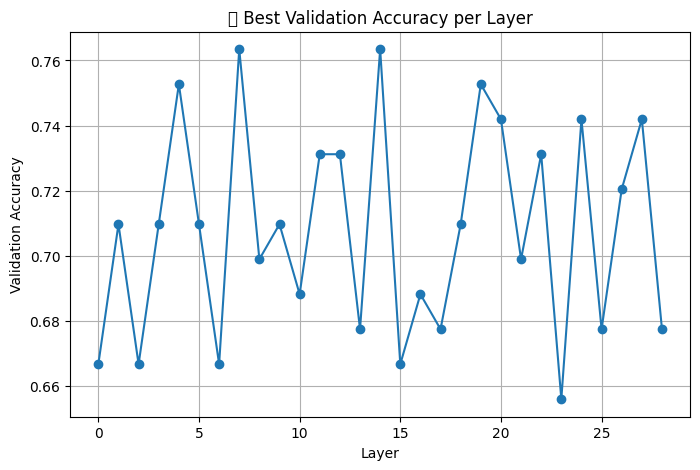

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


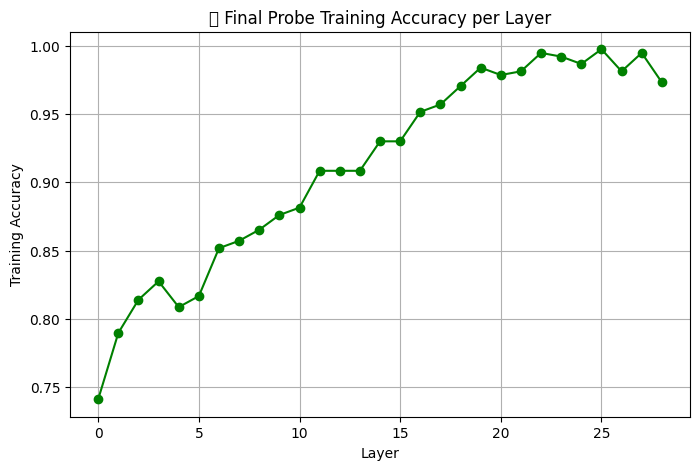

📊 Layer Summary:
 Layer  Best Val Accuracy
     7           0.763441
    14           0.763441
     4           0.752688
    19           0.752688
    20           0.741935
    24           0.741935
    27           0.741935
    22           0.731183
    12           0.731183
    11           0.731183
    26           0.720430
     9           0.709677
     3           0.709677
     5           0.709677
     1           0.709677
    18           0.709677
    21           0.698925
     8           0.698925
    16           0.688172
    10           0.688172
    13           0.677419
    28           0.677419
    25           0.677419
    17           0.677419
     0           0.666667
     6           0.666667
     2           0.666667
    15           0.666667
    23           0.655914


In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Summary Plot: Best Val Accuracy per Layer ---
layers = list(layer_results.keys())
accuracies = list(layer_results.values())

plt.figure(figsize=(8, 5))
plt.plot(layers, accuracies, marker='o')
plt.title("📈 Best Validation Accuracy per Layer")
plt.xlabel("Layer")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

# Take final training accuracy per layer (last epoch value)
train_final_acc = {layer: accs[-1] for layer, accs in layer_train_curves.items()}

# Sort by layer index
sorted_layers = sorted(train_final_acc.keys())
sorted_train_acc = [train_final_acc[layer] for layer in sorted_layers]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(sorted_layers, sorted_train_acc, marker='o', color='green')
plt.title("🧠 Final Probe Training Accuracy per Layer")
plt.xlabel("Layer")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

# --- DataFrame Summary ---
summary_df = pd.DataFrame({
    'Layer': layers,
    'Best Val Accuracy': accuracies
})
summary_df.sort_values("Best Val Accuracy", ascending=False, inplace=True)
print("📊 Layer Summary:")
print(summary_df.to_string(index=False))

In [29]:
def evaluate_probe_on_test(probe, test_layer_data):
    """
    Evaluate a trained probe on test activations.

    Args:
        probe (nn.Module): The trained probe.
        test_layer_data (dict): A dictionary with 'pivotal' and 'non_pivotal' activations for a single layer.

    Returns:
        float: Accuracy on the test set.
    """
    from torch.utils.data import DataLoader, TensorDataset
    probe.eval()

    # Prepare test inputs and labels
    X_pivotal = torch.stack(test_layer_data['pivotal'])
    X_non_pivotal = torch.stack(test_layer_data['non_pivotal'])
    y_pivotal = torch.ones(X_pivotal.size(0), 1)
    y_non_pivotal = torch.zeros(X_non_pivotal.size(0), 1)

    X_test = torch.cat([X_pivotal, X_non_pivotal], dim=0)
    y_test = torch.cat([y_pivotal, y_non_pivotal], dim=0)

    dataset = TensorDataset(X_test, y_test)
    loader = DataLoader(dataset, batch_size=32)

    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
            preds = (probe(X_batch) > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total



🧪 Training probe for layer 0
Layer 0 | Epoch 1 | Loss 16.5619 | Train Acc 0.6765 | Val Acc 0.6237
Layer 0 | Epoch 2 | Loss 16.3115 | Train Acc 0.7035 | Val Acc 0.6344
Layer 0 | Epoch 3 | Loss 16.1086 | Train Acc 0.7062 | Val Acc 0.6344
Layer 0 | Epoch 4 | Loss 15.9116 | Train Acc 0.7089 | Val Acc 0.6237
Layer 0 | Epoch 5 | Loss 15.7046 | Train Acc 0.7116 | Val Acc 0.6559
Layer 0 | Epoch 6 | Loss 15.5910 | Train Acc 0.7143 | Val Acc 0.6559
Layer 0 | Epoch 7 | Loss 15.3545 | Train Acc 0.7143 | Val Acc 0.6344
Layer 0 | Epoch 8 | Loss 15.2822 | Train Acc 0.7197 | Val Acc 0.6344
Layer 0 | Epoch 9 | Loss 15.1334 | Train Acc 0.7251 | Val Acc 0.6559
Layer 0 | Epoch 10 | Loss 15.0769 | Train Acc 0.7251 | Val Acc 0.6559
✅ Test accuracy for layer 0: 0.6538

🧪 Training probe for layer 1
Layer 1 | Epoch 1 | Loss 15.9863 | Train Acc 0.6819 | Val Acc 0.5914
Layer 1 | Epoch 2 | Loss 15.0557 | Train Acc 0.7358 | Val Acc 0.6559
Layer 1 | Epoch 3 | Loss 14.3265 | Train Acc 0.7520 | Val Acc 0.6667
Layer 

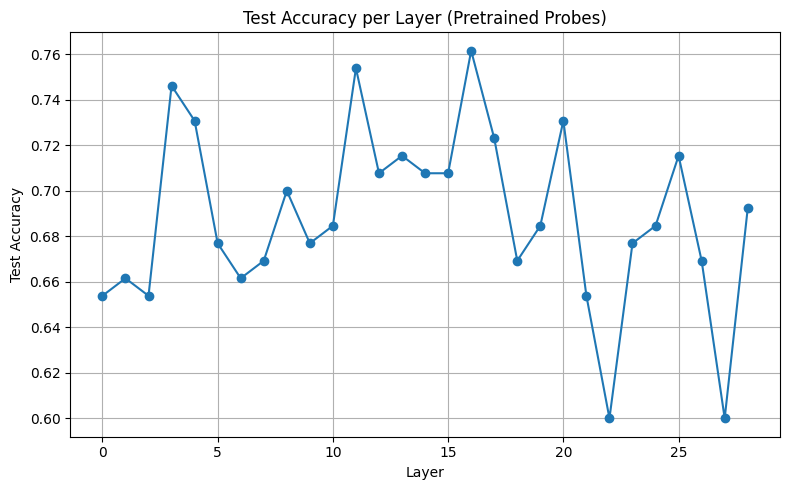

In [36]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Load test data once
test_data = torch.load("/content/drive/My Drive/Algoverse-AI-Model-Probing/cached_activations_3/test_all_layers_acts.pth", map_location='cpu')

layer_test_results = {}  # To store {layer: test_acc}

for layer_idx in data.keys():
    print(f"\n🧪 Training probe for layer {layer_idx}")

    try:
        best_val_acc, train_accuracies, val_accuracies, losses, trained_probe = train_probe_for_layer(layer_idx=layer_idx, data=data)
    except Exception as e:
        print(f"⚠️ Skipping layer {layer_idx} due to error: {e}")
        continue

    # Evaluate on test data
    if layer_idx in test_data:
        test_acc = evaluate_probe_on_test(trained_probe, test_data[layer_idx])
        print(f"✅ Test accuracy for layer {layer_idx}: {test_acc:.4f}")
        layer_test_results[layer_idx] = test_acc
    else:
        print(f"⚠️ No test data for layer {layer_idx}")

# === Summary & Plot ===
df = pd.DataFrame({
    'Layer': list(layer_test_results.keys()),
    'Test Accuracy': list(layer_test_results.values())
})

df.sort_values("Layer", inplace=True)  # 🛠️ Sort by layer before plotting

# Print summary
print("\n📊 Test Accuracy Summary:")
print(df.sort_values('Test Accuracy', ascending=False))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df['Layer'], df['Test Accuracy'], marker='o')
plt.title("Test Accuracy per Layer (Pretrained Probes)")
plt.xlabel("Layer")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

